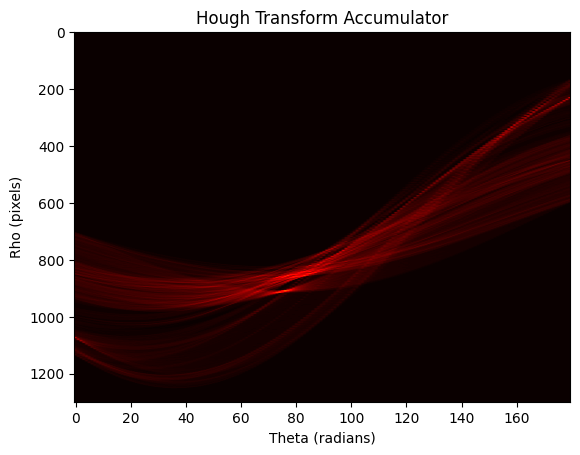

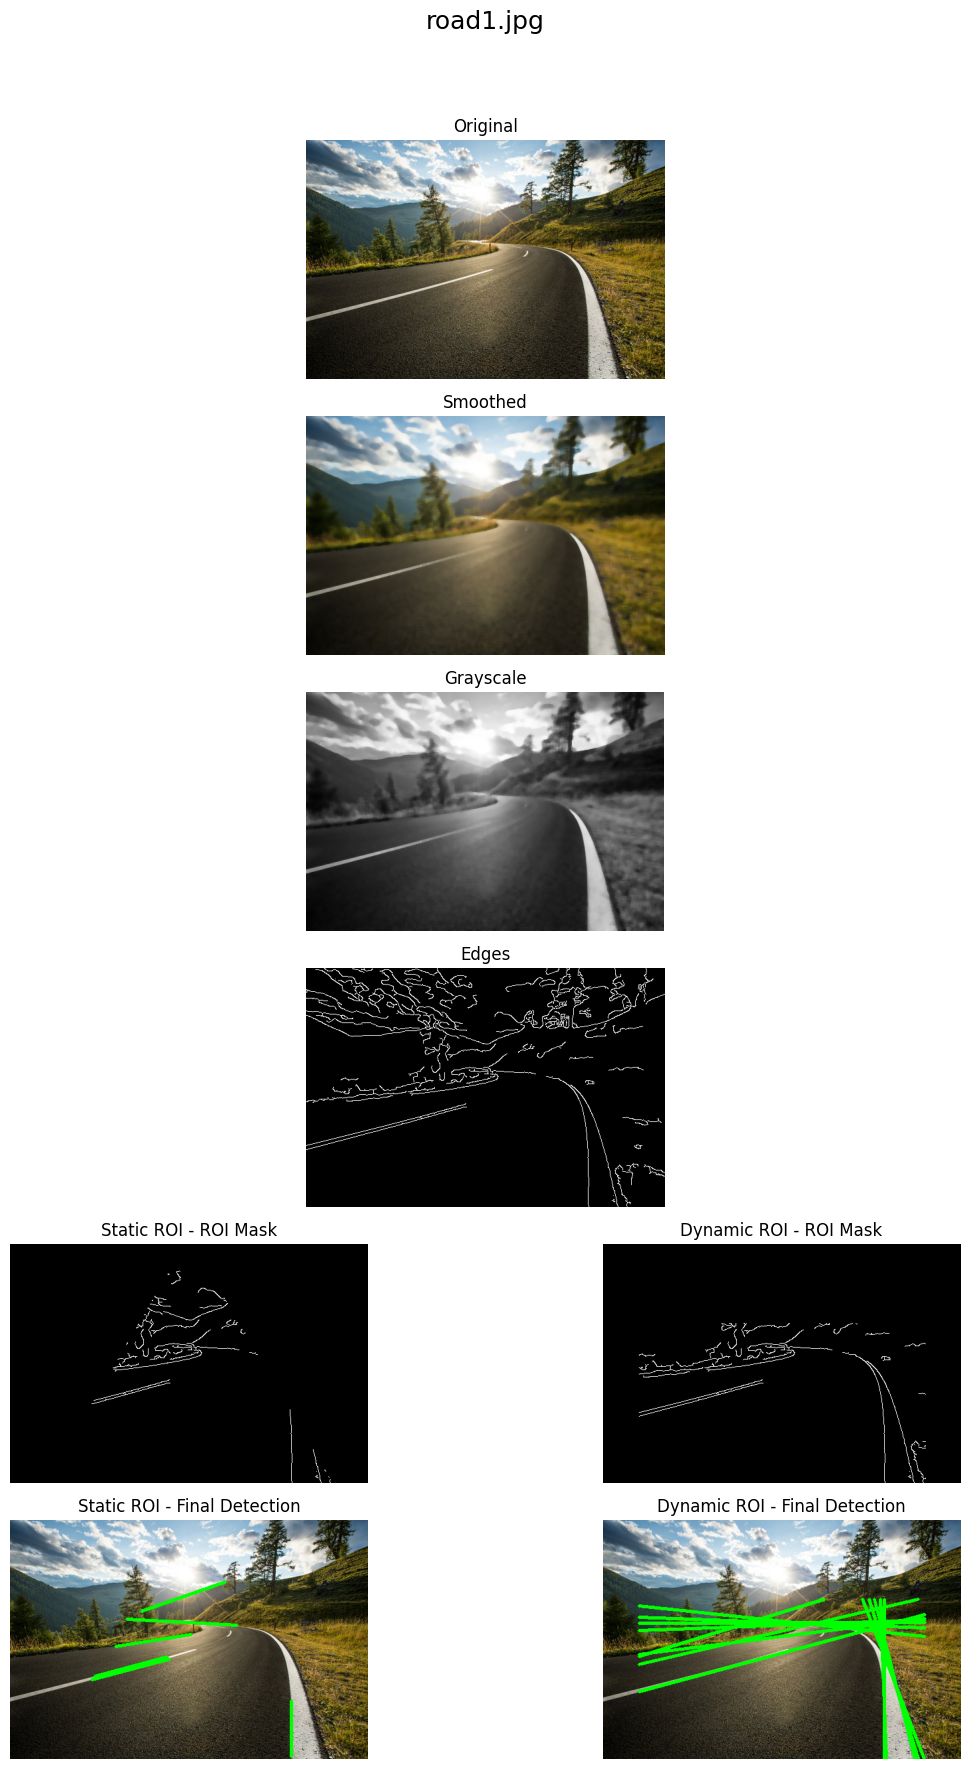

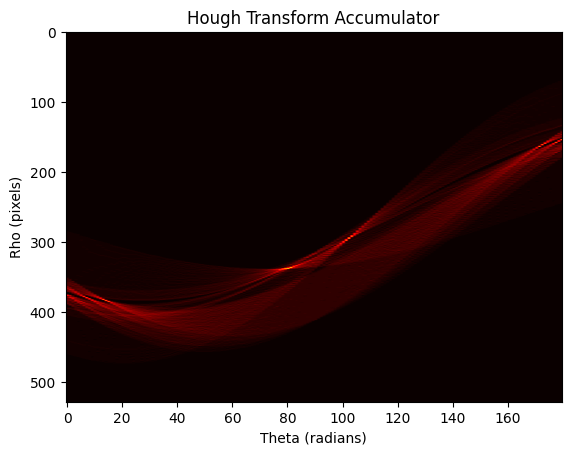

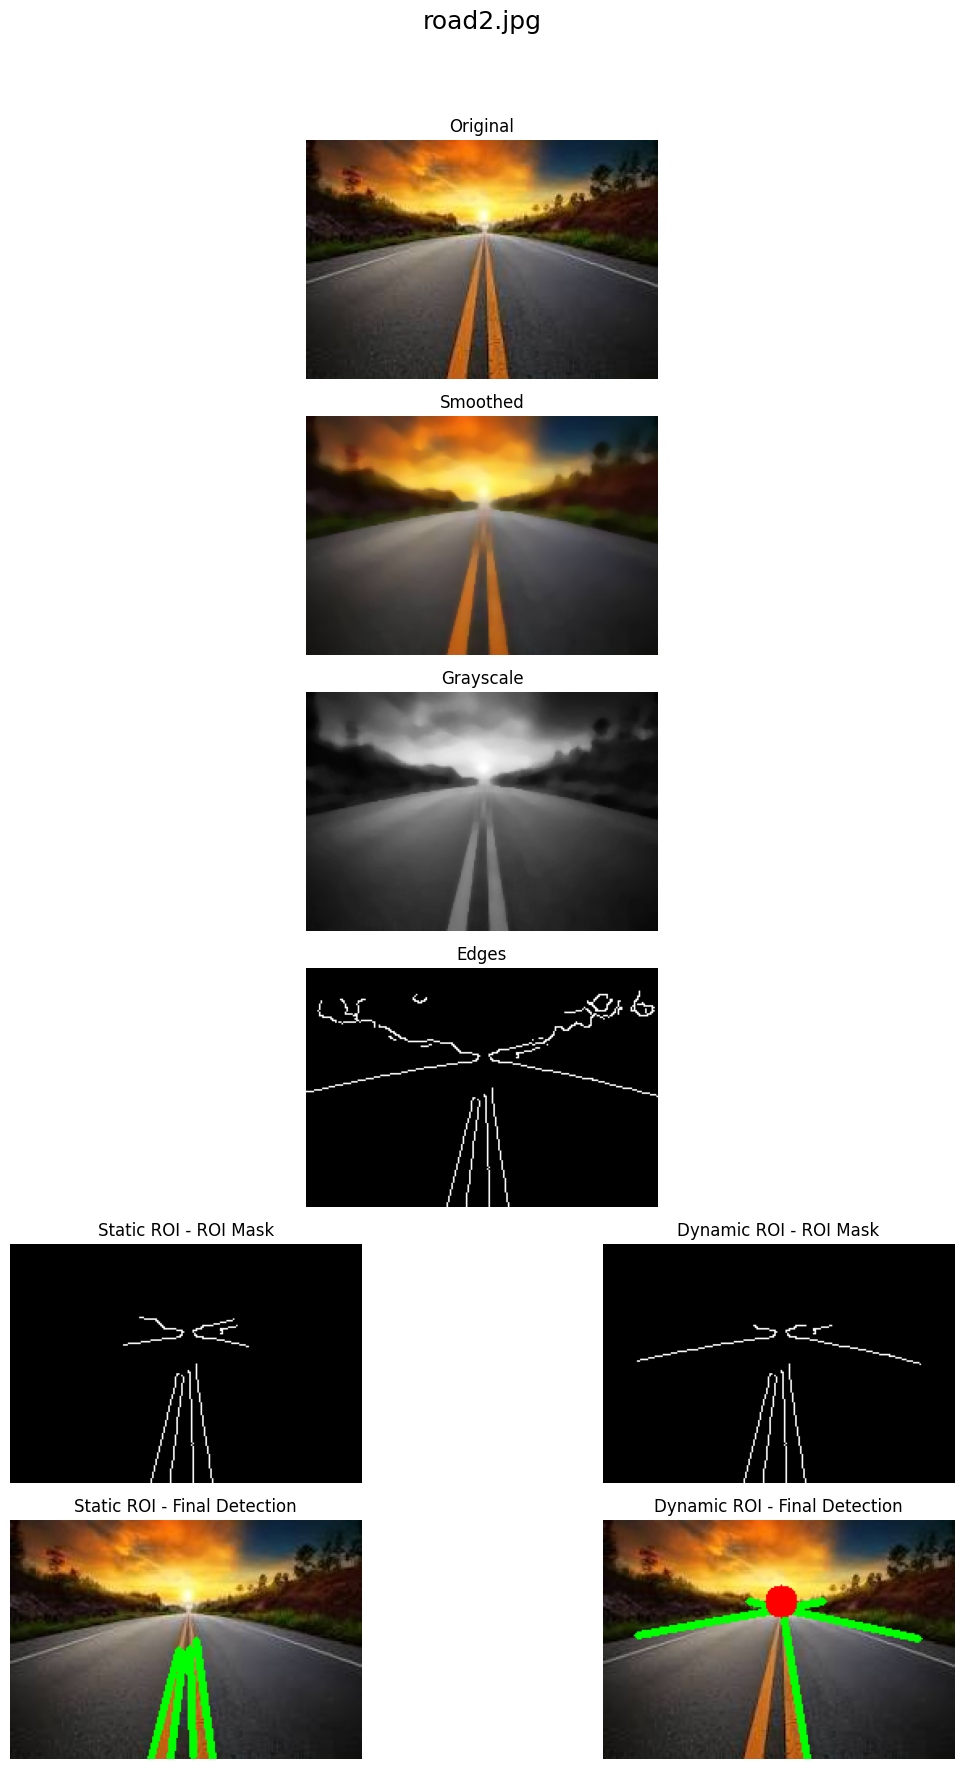

In [3]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
import matplotlib.gridspec as gridspec

# -------------------------------
# Static ROI Lane Detection Functions
# -------------------------------

def static_lane_detection_steps(image, median_ksize=7, canny_thresh1=50, canny_thresh2=150, 
                                hough_thresh=50, min_line_length=50, max_line_gap=150):
    steps = {}
    steps['original'] = image
    
    # 1. Smooth the image using a median filter.
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth
    
    # 2. Convert to grayscale.
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray
    
    # 3. Detect edges using the Canny edge detector.
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges
    
    # 4. Define a static (fixed) trapezoidal ROI.
    height, width = edges.shape
    roi_vertices = np.array([[
        (int(0.1 * width), height),                # Bottom left.
        (int(0.45 * width), int(0.1 * height)),      # Top left.
        (int(0.55 * width), int(0.1 * height)),      # Top right.
        (int(0.9 * width), height)                   # Bottom right.
    ]], dtype=np.int32)
    steps['static_roi_vertices'] = roi_vertices
    
    # 5. Apply the ROI mask.
    roi_mask = np.zeros_like(edges)
    cv2.fillPoly(roi_mask, [roi_vertices], 255)
    roi_edges = cv2.bitwise_and(edges, roi_mask)
    steps['roi_edges_static'] = roi_edges
    
    # 6. Detect lane lines using Hough Transform.
    lines = cv2.HoughLinesP(roi_edges, rho=1, theta=np.pi/180, threshold=hough_thresh,
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    lane_img = image.copy()
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    steps['lane_detection_static'] = lane_img
    
    return steps

# -------------------------------
# Dynamic ROI Lane Detection Functions and manual hough-space accumulation
# -------------------------------

def detect_vanishing_point(edges, hough_thresh=50, min_line_length=50, max_line_gap=150):
    lines = cv2.HoughLinesP(edges, rho=1, theta=np.pi/180, threshold=hough_thresh, 
                            minLineLength=min_line_length, maxLineGap=max_line_gap)
    if lines is None:
        return None

    slopes = []
    intercepts = []
    for line in lines:
        x1, y1, x2, y2 = line[0]
        if x2 - x1 == 0:  # Avoid division by zero.
            continue
        m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        slopes.append(m)
        intercepts.append(b)
    
    vp_x = []
    vp_y = []
    for i in range(len(slopes)):
        for j in range(i+1, len(slopes)):
            if slopes[i] == slopes[j]:
                continue
            x_intersect = (intercepts[j] - intercepts[i]) / (slopes[i] - slopes[j])
            y_intersect = slopes[i] * x_intersect + intercepts[i]
            vp_x.append(x_intersect)
            vp_y.append(y_intersect)
    
    if len(vp_x) == 0:
        return None

    vanishing_point = (int(np.mean(vp_x)), int(np.mean(vp_y)))
    return vanishing_point

def manual_hough_transform(edge_image):
    height, width = edge_image.shape
    diag_len = int(np.ceil(np.sqrt(height**2 + width**2)))
    rhos = np.arange(-diag_len, diag_len + 1, 1) #ranges for rho
    thetas = np.deg2rad(np.arange(0, 180)) #ranges for theta
    accumulator = np.zeros((len(rhos), len(thetas)), dtype=np.uint64)
    edge_points = np.argwhere(edge_image != 0) # return all possible x,y combinations
    
    # Vectorized voting
    for theta_idx, theta in enumerate(thetas):
        rho_vals = edge_points[:, 1] * np.cos(theta) + edge_points[:, 0] * np.sin(theta)
        rho_idxs = (rho_vals + diag_len).astype(int)
        np.add.at(accumulator, (rho_idxs, theta_idx), 1)
            
    plt.imshow(accumulator, cmap='hot', aspect='auto')
    plt.xlabel("Theta (radians)")
    plt.ylabel("Rho (pixels)")
    plt.title("Hough Transform Accumulator")
    plt.show()
    return accumulator, rhos, thetas

def non_maximum_suppression(accumulator, threshold=10, neighborhood_size=5):
    peaks = []
    acc_copy = accumulator.copy()

    for r_idx in range(acc_copy.shape[0]):
        for t_idx in range(acc_copy.shape[1]):
            if acc_copy[r_idx, t_idx] < threshold:
                continue
            
            min_r = max(r_idx - neighborhood_size, 0)
            max_r = min(r_idx + neighborhood_size + 1, acc_copy.shape[0])
            min_t = max(t_idx - neighborhood_size, 0)
            max_t = min(t_idx + neighborhood_size + 1, acc_copy.shape[1])
            
            if acc_copy[r_idx, t_idx] == np.max(acc_copy[min_r:max_r, min_t:max_t]):
                peaks.append((r_idx, t_idx))
                acc_copy[min_r:max_r, min_t:max_t] = 0
    
    return peaks

def get_hough_lines(peaks, rhos, thetas, image_shape, line_length_factor=1.0):
    height, width = image_shape[:2]
    diag_len = int(np.ceil(np.sqrt(height**2 + width**2))) * line_length_factor
    lines = []
    
    if not peaks:
        print("Warning: No peaks detected. Try lowering the threshold in non_maximum_suppression.")
    
    for (rho_idx, theta_idx) in peaks:
        rho = rhos[rho_idx]
        theta = thetas[theta_idx]
        
        a = np.cos(theta)
        b = np.sin(theta)
        x0 = a * rho
        y0 = b * rho
        
        pt1 = (int(x0 + diag_len * (-b)), int(y0 + diag_len * (a)))
        pt2 = (int(x0 - diag_len * (-b)), int(y0 - diag_len * (a)))
        
        lines.append((pt1[0], pt1[1], pt2[0], pt2[1]))
    
    return lines

def dynamic_lane_detection_steps(image, median_ksize=7, canny_thresh1=50, canny_thresh2=150, 
                                  hough_thresh=50, min_line_length=50, max_line_gap=150):
    steps = {}
    steps['original'] = image
    
    # 1. Smooth the image.
    smooth = cv2.medianBlur(image, median_ksize)
    steps['smoothed'] = smooth
    
    # 2. Convert to grayscale.
    gray = cv2.cvtColor(smooth, cv2.COLOR_BGR2GRAY)
    steps['grayscale'] = gray
    
    # 3. Detect edges using Canny.
    edges = cv2.Canny(gray, canny_thresh1, canny_thresh2)
    steps['edges'] = edges
    
    # 4. Detect vanishing point.
    vp = detect_vanishing_point(edges, hough_thresh, min_line_length, max_line_gap)
    steps['vanishing_point'] = vp
    
    height, width = edges.shape
    if vp is None:
        x_min = int(0.1 * width)
        y_min = int(0.1 * height)
        x_max = int(0.9 * width)
        y_max = height
    else:
        vp_x, vp_y = vp
        x_min = int(0.1 * width)
        y_min = vp_y
        x_max = int(0.9 * width)
        y_max = height

    roi_vertices = np.array([[x_min, y_min], [x_max, y_min], [x_max, y_max], [x_min, y_max]], dtype=np.int32)
    steps['dynamic_roi_vertices'] = roi_vertices
    
    # 6. Apply the ROI mask.
    roi_mask = np.zeros_like(edges)
    cv2.fillPoly(roi_mask, [roi_vertices], 255)
    roi_edges = cv2.bitwise_and(edges, roi_mask)
    steps['roi_edges_dynamic'] = roi_edges
    
    # 7. Detect lane lines using manual Hough Transform.
    accumulator, rhos, thetas = manual_hough_transform(roi_edges)
    peaks = non_maximum_suppression(accumulator, threshold=50, neighborhood_size=8)
    lines = get_hough_lines(peaks, rhos, thetas, image.shape, line_length_factor=1.0)
    
    roi_for_clip = (x_min, y_min, x_max - x_min, y_max - y_min)
    
    clipped_lines = []
    for line in lines:
        pt1 = (line[0], line[1])
        pt2 = (line[2], line[3])
        retval, clipped_pt1, clipped_pt2 = cv2.clipLine(roi_for_clip, pt1, pt2)
        if retval:
            clipped_lines.append((clipped_pt1[0], clipped_pt1[1], clipped_pt2[0], clipped_pt2[1]))
    
    lane_img = image.copy()
    if clipped_lines:
        for line in clipped_lines:
            x1, y1, x2, y2 = line
            cv2.line(lane_img, (x1, y1), (x2, y2), (0, 255, 0), 3)
    else:
        cv2.polylines(lane_img, [roi_vertices], True, (255, 0, 0), 2)
        
    if vp is not None:
        cv2.circle(lane_img, vp, 10, (0, 0, 255), -1)
    steps['lane_detection_dynamic'] = lane_img
    
    return steps

def display_lane_intermediate_comparison(static_steps, dynamic_steps, image_title="Intermediate Comparison"):
    common_steps = ["Original", "Smoothed", "Grayscale", "Edges"]
    common_keys = ["original", "smoothed", "grayscale", "edges"]
    
    comp_steps = ["ROI Mask", "Final Detection"]
    static_comp_keys = ["roi_edges_static", "lane_detection_static"]
    dynamic_comp_keys = ["roi_edges_dynamic", "lane_detection_dynamic"]

    fig = plt.figure(figsize=(12, 18))
    gs = gridspec.GridSpec(6, 2)
    
    for i, (step_name, key) in enumerate(zip(common_steps, common_keys)):
        ax = fig.add_subplot(gs[i, :])
        img = static_steps[key]
        if len(img.shape) == 2:
            ax.imshow(img, cmap='gray')
        else:
            ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        ax.set_title(step_name)
        ax.axis("off")
    
    for j, step_name in enumerate(comp_steps):
        ax_static = fig.add_subplot(gs[4+j, 0])
        img_static = static_steps[static_comp_keys[j]]
        if len(img_static.shape) == 2:
            ax_static.imshow(img_static, cmap='gray')
        else:
            ax_static.imshow(cv2.cvtColor(img_static, cv2.COLOR_BGR2RGB))
        ax_static.set_title(f"Static ROI - {step_name}")
        ax_static.axis("off")
        
        ax_dynamic = fig.add_subplot(gs[4+j, 1])
        img_dynamic = dynamic_steps[dynamic_comp_keys[j]]
        if len(img_dynamic.shape) == 2:
            ax_dynamic.imshow(img_dynamic, cmap='gray')
        else:
            ax_dynamic.imshow(cv2.cvtColor(img_dynamic, cv2.COLOR_BGR2RGB))
        ax_dynamic.set_title(f"Dynamic ROI - {step_name}")
        ax_dynamic.axis("off")
    
    plt.suptitle(image_title, fontsize=18)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

def process_lane_images_folder(folder_path):
    image_paths = glob.glob(os.path.join(folder_path, '*.*'))
    
    for image_path in image_paths:
        image = cv2.imread(image_path)
        if image is None:
            print(f"Error reading image: {image_path}")
            continue
        
        static_steps = static_lane_detection_steps(image)
        dynamic_steps = dynamic_lane_detection_steps(image)
        title = os.path.basename(image_path)
        
        display_lane_intermediate_comparison(static_steps, dynamic_steps, image_title=title)
        
if __name__ == '__main__':
    folder = 'road_images'  # Folder containing your set of road images.
    process_lane_images_folder(folder)